In [1]:
import os
from os.path import join as oj
import sys, time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data_pecarn
import data_psrc
import data
import matplotlib.gridspec as grd
import viz
import style
from style import *

# sns.set(style="black")
# plt.style.use('dark_background')
outcome_def = 'iai_intervention' # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module

# combined

In [2]:
dummy = True
df_pecarn = data_pecarn.get_data(dummy=dummy)
feat_names, pecarn_feat_names = data.get_feat_names(df_pecarn)

df_psrc = data_psrc.get_data(dummy=dummy)
feat_names, psrc_feat_names = data.get_feat_names(df_psrc)

computing pecarn preprocessing...
computing psrc preprocessing...


In [3]:
feat_names = [k for k in psrc_feat_names if k in pecarn_feat_names]
meta = [outcome_def, 'cv_fold', 'dset']
common_feats = feat_names + meta
df1 = df_pecarn[common_feats]
df2 = df_psrc[common_feats]
df = df1.append(df2) # pd.concat((df1, df2), axis=0)


df = df[df.cv_fold.isin(data.pecarn_train_idxs)] # only use train idxs
# don't include doubles for binary features

processed_feats = data.select_final_feats(feat_names)
print(len(feat_names), sorted(feat_names), '\n\n', len(processed_feats), sorted(processed_feats))

44 ['AbdDistention_no', 'AbdDistention_unknown', 'AbdDistention_yes', 'AbdTenderDegree_Mild', 'AbdTenderDegree_Moderate', 'AbdTenderDegree_Severe', 'AbdTenderDegree_unknown', 'AbdTrauma_no', 'AbdTrauma_or_SeatBeltSign_no', 'AbdTrauma_or_SeatBeltSign_yes', 'AbdTrauma_yes', 'AbdomenPain_no', 'AbdomenPain_yes', 'Age', 'CostalTender', 'DecrBreathSound_no', 'DecrBreathSound_yes', 'GCSScore', 'GCSScore_Full_no', 'GCSScore_Full_yes', 'Hypotension', 'InitHeartRate', 'InitSysBPRange', 'LtCostalTender', 'MOI_Bike collision/fall', 'MOI_Fall from an elevation', 'MOI_Motor vehicle collision', 'MOI_Motorcycle/ATV/Scooter collision', 'MOI_Object struck abdomen', 'MOI_Pedestrian/bicyclist struck by moving vehicle', 'MOI_unknown', 'Race_American Indian or Alaska Native', 'Race_Asian', 'Race_Black or African American', 'Race_White', 'Race_unknown', 'RtCostalTender', 'SeatBeltSign_no', 'SeatBeltSign_yes', 'ThoracicTrauma_no', 'ThoracicTrauma_yes', 'VomitWretch_no', 'VomitWretch_unknown', 'VomitWretch_yes

In [ ]:
# corrs = df[feat_names + [outcome_def]].corr()
corrs = df[processed_feats + [outcome_def]].corr(method='spearman')
sns.clustermap(corrs, cmap=style.cmap_div)
plt.savefig('results/corrplot.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(dpi=300, figsize=(4, 7))
vals = corrs['iai_intervention']
args = np.argsort(vals)
labs = corrs['iai_intervention'][args].index.values
plt.barh(labs[:-1], vals[args][:-1])
plt.xlabel('spearman correlation w/ outcome')
plt.show()

# features scatter plots

## continuous features

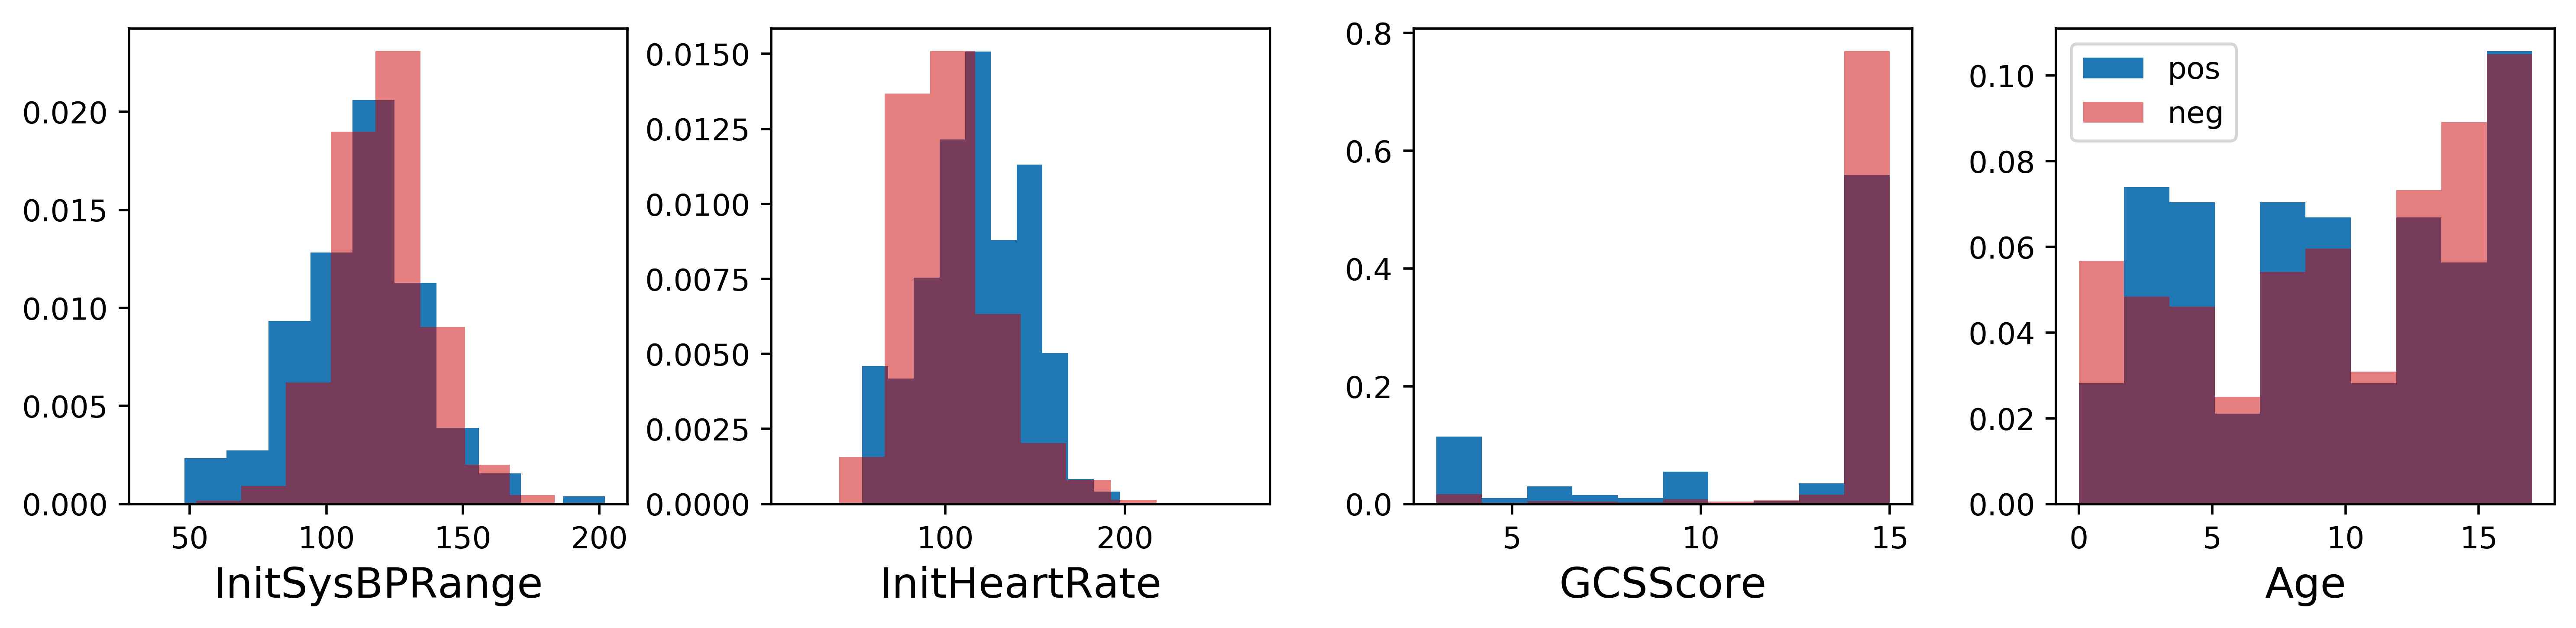

In [6]:
R, C, = 1, 4
plt.figure(figsize=(12, 3), dpi=500)
for i in range(len(data.feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = data.feats_numerical[i]
    plt.hist(df[df[outcome_def] == 1][feat], density=True, alpha=1, label='pos', color=cb)
    plt.hist(df[df[outcome_def] == 0][feat], density=True, alpha=0.5, label='neg', color=cr)
    plt.xlabel(feat, fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

**we can cut GCSScore as whether it is 15 or not (14 is already pretty bad)**

In [7]:
feat = 'GCSScore'
print(np.unique(df[df[outcome_def] == 1][feat], return_counts=True))
print(np.unique(df[df[outcome_def] == 0][feat], return_counts=True))

(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 13., 14., 15.]), array([22,  1,  2,  6,  3,  2,  5,  6,  1,  7, 19, 93]))
(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]), array([ 176,   22,   25,   56,   48,   31,   50,   46,   53,   71,  186,
        535, 8605]))


## categorical feats

## binary feats

**venn plot**

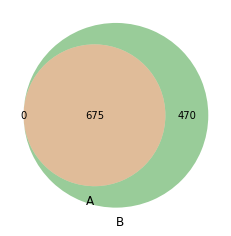

In [8]:
# df['CostalTender'] = ((df['LtCostalTender'] == 1) | (df['RtCostalTender'] == 1)) * 1
from matplotlib_venn import venn2
cind = df[df['LtCostalTender']==1].index.values
rind = df[df['CostalTender']==1].index.values
venn2((set(cind), set(rind)))
plt.show()

# scatter plots

ValueError: Could not interpret input 'Sex_F'

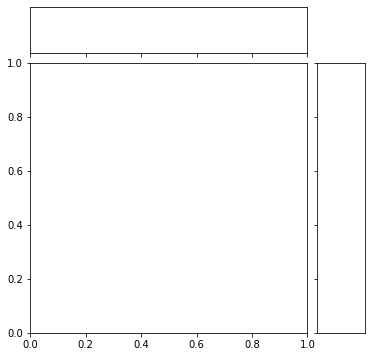

In [9]:
viz.jointplot_grouped('Age', 'Sex_F', 'iai_intervention', df1) # this is using the df that still has gender
# , k_is_color=False, scatter_alpha=.5, add_global_hists: bool=True):

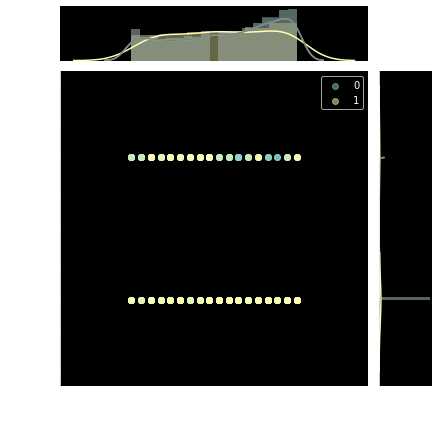

In [34]:
viz.jointplot_grouped('Age', 'AbdDistention_yes', 'iai_intervention', df) # this is using the df that still has gender
# , k_is_color=False, scatter_alpha=.5, add_global_hists: bool=True):

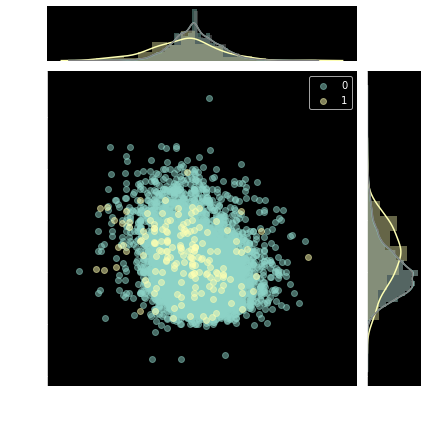

In [36]:
viz.jointplot_grouped('InitSysBPRange', 'InitHeartRate', 'iai_intervention', df) # this is using the df that still has gender
# , k_is_color=False, scatter_alpha=.5, add_global_hists: bool=True):

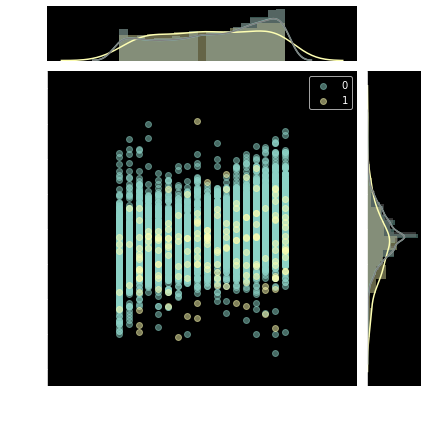

In [9]:
viz.jointplot_grouped('Age', 'InitSysBPRange', 'iai_intervention', df) # this is using the df that still has gender
# , k_is_color=False, scatter_alpha=.5, add_global_hists: bool=True):

In [28]:
df_pecarn.keys()

Index(['id', 'AbdCTScan', 'AbdCTScan1', 'AbdUltrasound', 'AbdUltrasound1',
       'AbdomenTender', 'AbnChestAusc', 'AlcDrgSuspicion', 'BowelSounds',
       'Certification',
       ...
       'MOI_Motor vehicle collision', 'MOI_Motorcycle/ATV/Scooter collision',
       'MOI_Object struck abdomen',
       'MOI_Pedestrian/bicyclist struck by moving vehicle', 'MOI_unknown',
       'AbdTrauma_or_SeatBeltSign_no', 'AbdTrauma_or_SeatBeltSign_yes',
       'GCSScore_Full_no', 'GCSScore_Full_yes', 'dset'],
      dtype='object', length=119)